In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [3]:
f = h5py.File("../model/AllParametersTMC2DRBM_NGibbs_50_Nh100_Nv1000_Nmb200_Nepoch100_lr_0.1_N20000_Npoint2500_Nchain10.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)

In [4]:
t = 1
lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50

In [5]:
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

In [6]:
myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g


In [7]:
f.keys()

<KeysViewHDF5 ['W0', 'W1', 'W10', 'W12', 'W14', 'W15', 'W16', 'W18', 'W2', 'W22', 'W24', 'W25', 'W26', 'W28', 'W3', 'W32', 'W38', 'W4', 'W41', 'W42', 'W43', 'W45', 'W48', 'W49', 'W5', 'W55', 'W6', 'W8', 'W9', 'alltime', 'hbias0', 'hbias1', 'hbias10', 'hbias12', 'hbias14', 'hbias15', 'hbias16', 'hbias18', 'hbias2', 'hbias22', 'hbias24', 'hbias25', 'hbias26', 'hbias28', 'hbias3', 'hbias32', 'hbias38', 'hbias4', 'hbias41', 'hbias42', 'hbias43', 'hbias45', 'hbias48', 'hbias49', 'hbias5', 'hbias55', 'hbias6', 'hbias8', 'hbias9', 'p_m0', 'p_m1', 'p_m10', 'p_m12', 'p_m14', 'p_m15', 'p_m16', 'p_m18', 'p_m2', 'p_m22', 'p_m24', 'p_m25', 'p_m26', 'p_m28', 'p_m3', 'p_m32', 'p_m38', 'p_m4', 'p_m41', 'p_m42', 'p_m43', 'p_m45', 'p_m48', 'p_m49', 'p_m5', 'p_m55', 'p_m6', 'p_m8', 'p_m9', 'vbias0', 'vbias1', 'vbias10', 'vbias12', 'vbias14', 'vbias15', 'vbias16', 'vbias18', 'vbias2', 'vbias22', 'vbias24', 'vbias25', 'vbias26', 'vbias28', 'vbias3', 'vbias32', 'vbias38', 'vbias4', 'vbias41', 'vbias42', 'vb

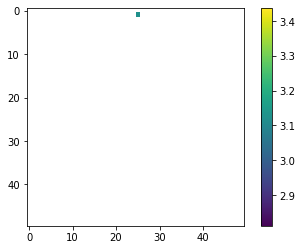

In [8]:
plt.imshow(torch.log(torch.tensor(f['p_m55'])))
plt.colorbar()

<ipython-input-9-fda376e67c69>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_data =torch.mm(torch.tensor(data, device= device, dtype = dtype), V_g).cpu()/myRBM.Nv**0.5


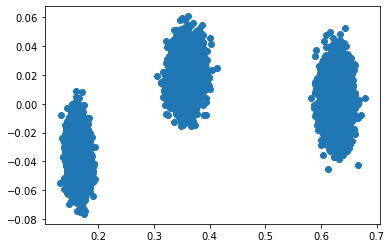

In [9]:
proj_data =torch.mm(torch.tensor(data, device= device, dtype = dtype), V_g).cpu()/myRBM.Nv**0.5
plt.scatter(proj_data[:,0], proj_data[:,1])

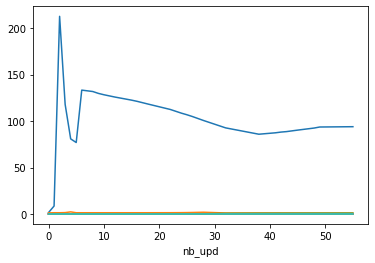

In [12]:
S = torch.zeros(10, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f['W'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    #plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:10]
#plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)
plt.plot(alltimes,S.T.cpu())
plt.xlabel("nb_upd");